In [1]:
import astropy
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.visualization import ImageNormalize, SqrtStretch, AsinhStretch

import sunpy
from sunpy.map import Map
from sunpy.map.header_helper import make_fitswcs_header
from sunpy.coordinates.frames import Helioprojective, HeliographicStonyhurst

import matplotlib.pyplot as plt

from aiapy.calibrate import normalize_exposure, register, update_pointing

In [2]:
with fits.open("20221002_202732_kcor_l2.fts") as hdu:
    pB = hdu[0].data
    header = hdu[0].header

In [3]:
kcor_map = Map(pB, header)

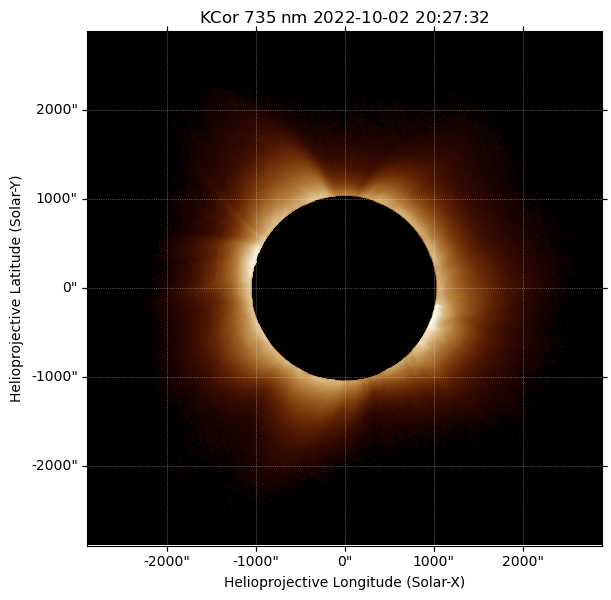

In [5]:
fig = plt.figure(figsize=(6,6), constrained_layout=True)

norm = ImageNormalize(pB, stretch=AsinhStretch(), vmin=0)
ax = fig.add_subplot(projection=kcor_map)
kcor_map.plot(axes=ax, cmap='sdoaia193', norm=norm)

In [6]:
from sunpy.net import Fido, attrs as a

result = Fido.search(a.Time('2022-10-02T20:27:00', '2022-10-02T20:28:00'),
                     a.Instrument("aia"), a.Wavelength(193 * u.angstrom))
                     #a.jsoc.Notify('solar@example.com'))
result.show()
downloaded_files = Fido.fetch(result)

aia_filename = downloaded_files[0]
aia_map = register(update_pointing(Map(aia_filename)))

Files Downloaded:   0%|          | 0/5 [00:00<?, ?file/s]

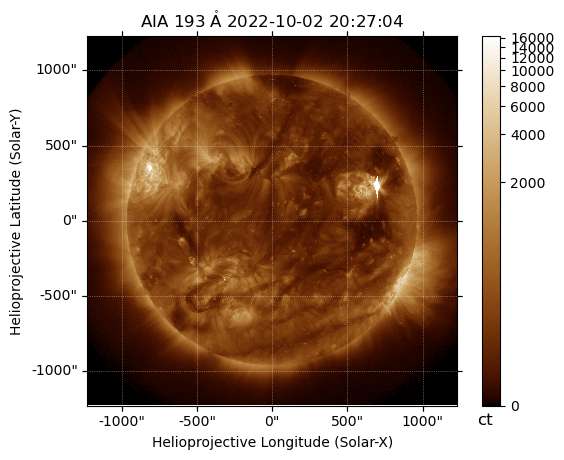

In [7]:
aia_map.peek(vmin=0)

In [8]:
aia_map_reproject = aia_map.reproject_to(WCS(header))

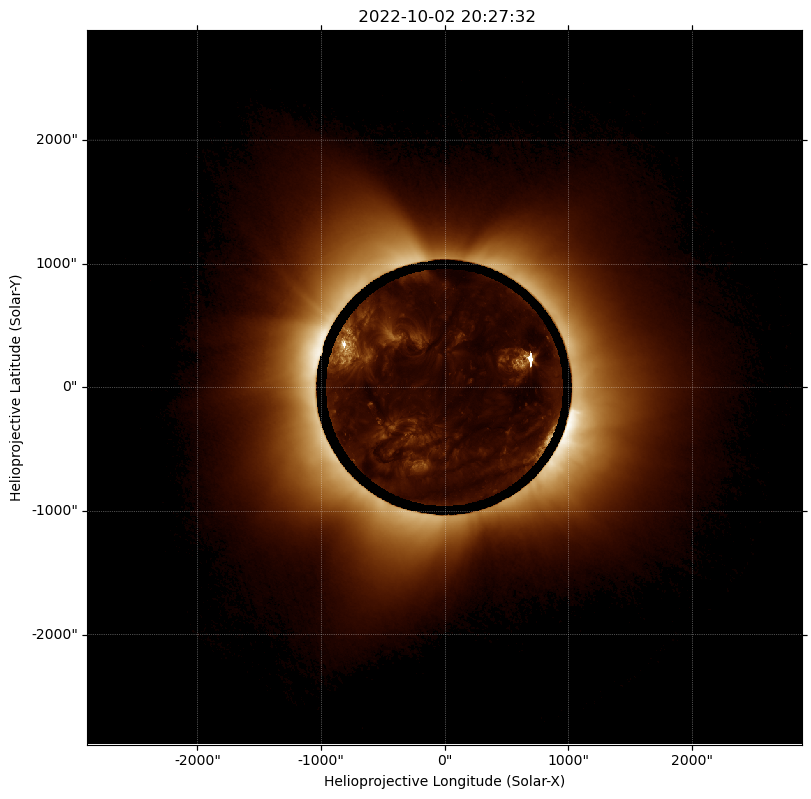

In [9]:
fig = plt.figure(figsize=(8,8), constrained_layout=True)

norm_aia = ImageNormalize(aia_map_reproject.data, stretch=AsinhStretch(), vmin=0)
ax = fig.add_subplot(projection=kcor_map)

kcor_map.plot(axes=ax, cmap='sdoaia193', norm=norm)

aia_map_reproject.plot(axes=ax, cmap='sdoaia193', norm=norm_aia, autoalign=True)